In [1]:
%pylab inline

import numpy as np

import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt

np.random.seed(6)

Populating the interactive namespace from numpy and matplotlib


### Degeneracy between faint, widely-separated dipole and bright, close dipole:

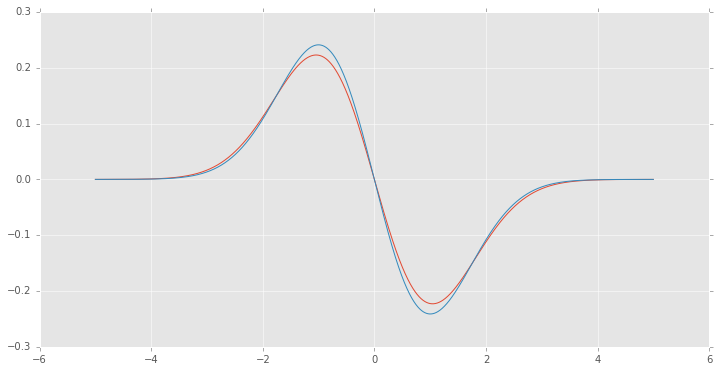

In [2]:
from scipy.stats import norm

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

x = np.arange(-5,5, 0.001)
plt.plot(x, 1. * (norm.pdf(x, -0.5, 1) - norm.pdf(x, 0.5, 1)))   ## faint, distant diple
plt.plot(x, 5. * (norm.pdf(x, -0.1, 1) - norm.pdf(x, 0.1, 1)))   ## bright, close dipole
plt.show()

### In the below, set amp1=1.3, sep1=0.8, amp2=5.0, amp2=0.2 ...

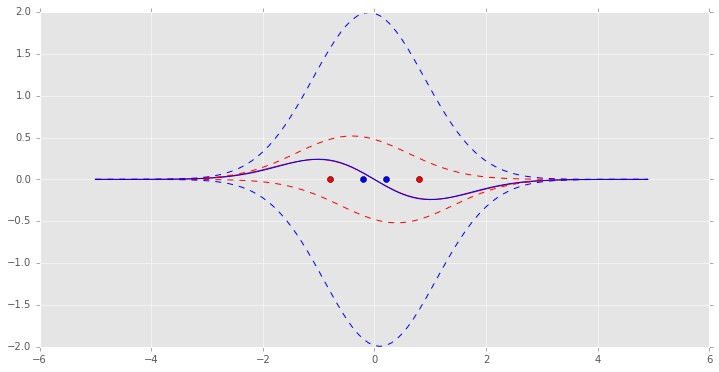

<function __main__.do_plot>

In [3]:
from ipywidgets import interact

def do_plot(amp1=1.3, sep1=0.8, amp2=5., sep2=0.2, show_components=True):
    x = np.arange(-5, 5, 0.1)
    plt.plot(x, amp1 * (norm.pdf(x, -sep1/2., 1) - norm.pdf(x, sep1/2., 1)), color='red')   ## faint, distant diple
    plt.plot(x, amp2 * (norm.pdf(x, -sep2/2., 1) - norm.pdf(x, sep2/2., 1)), color='blue')   ## bright, close dipole
    if show_components:
        plt.plot(x, amp1 *  norm.pdf(x, -sep1/2., 1), linestyle='dashed', color='red')
        plt.plot(x, amp1 * -norm.pdf(x,  sep1/2., 1), linestyle='dashed', color='red')
        plt.plot(x, amp2 *  norm.pdf(x, -sep2/2., 1), linestyle='dashed', color='blue')
        plt.plot(x, amp2 * -norm.pdf(x,  sep2/2., 1), linestyle='dashed', color='blue')
        
    plt.plot([-sep1, sep1], [0,0], 'ro')
    plt.plot([-sep2, sep2], [0,0], 'bo')
    plt.show()
    
##do_plot()

interact(do_plot, amp1=(0., 10.), sep1=(0., 2.), amp2=(0., 10.), sep2=(0., 2.), show_components=True)

### Try fitting it...

In [4]:
import lmfit

def gen_dipole2(x, amp1=1., sep1=1.):
    ypos = amp1 * norm.pdf(x,  sep1/2., 1)
    yneg = amp1 * norm.pdf(x, -sep1/2., 1)                  
    y = ypos - yneg
    return np.append(y, [ypos, yneg])

def gen_dipole(x, amp1=1., sep1=1.):
    #y = amp1 * (norm.pdf(x, -sep1/2., 1) - norm.pdf(x, sep1/2., 1))
    y = gen_dipole2(x, amp1, sep1)[:len(x)]
    return y

def fitDipole(ydata, xdata, amp1Start=3., sep1Start=2., fitFunc=gen_dipole, verbose=False):
    gmod = lmfit.Model(fitFunc, verbose=verbose)
    result = gmod.fit(ydata, x=xdata, amp1=amp1Start, sep1=sep1Start, verbose=verbose)

    if verbose: 
        print(result.fit_report(show_correl=False))
        ci = lmfit.conf_interval(result, result)
        lmfit.printfuncs.report_ci(ci)

    return result

 - Adding parameter "sep1"
 - Adding parameter "amp1"
[[Model]]
    Model(gen_dipole)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 40
    # variables        = 2
    chi-square         = 0.065
    reduced chi-square = 0.002
[[Variables]]
    sep1:   0.78723195 +/- 0.666462 (84.66%) (init= 1.5)
    amp1:   1.35282341 +/- 1.061277 (78.45%) (init= 1.5)



/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/confidence.py:298: UserWarning: Warning, rel_change=-0.44776020524 < 0.01  at iteration 2 and prob(sep1=-0.545692998819) = 0.23293232961 < max(sigmas).


         99.70%    95.00%    67.40%    _BEST_    67.40%    95.00%    99.70%
 sep1:      -inf      -inf      -inf   0.78723  +0.51520  +0.89202  +1.23595
 amp1:  -0.75214  -0.65093  -0.48704   1.35282      +inf      +inf      +inf


/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/confidence.py:298: UserWarning: Warning, rel_change=9.88590020343e-06 < 0.01  at iteration 64 and prob(amp1=69.2745666097) = 0.430748661324 < max(sigmas).


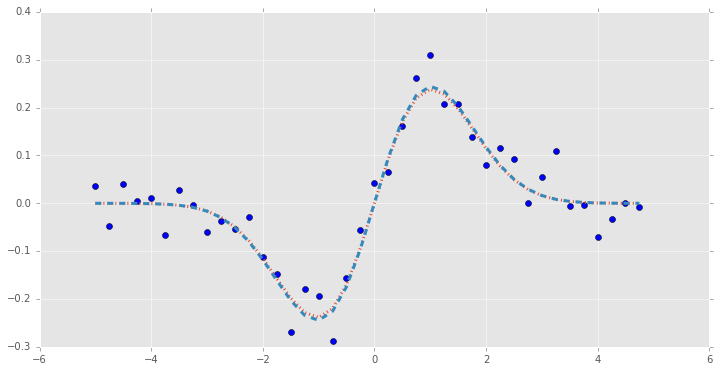

In [5]:
xdata = np.arange(-5, 5, 0.25)
ydataOrig = gen_dipole2(xdata, amp1=1.3, sep1=0.8)
ydataOrigNoisy = ydataOrig + np.random.normal(scale=0.03, size=ydataOrig.shape) ## save it for fitting below...
#ydata = ydataOrigNoisy[:len(xdata)]    ## only fit the dipole (not pos/neg images)
ydata = ydataOrigNoisy[len(xdata):2*len(xdata)] - ydataOrigNoisy[2*len(xdata):]

result = fitDipole(ydata, xdata, amp1Start=1.5, sep1Start=1.5, fitFunc=gen_dipole, verbose=True)
plt.plot(xdata, ydata, 'bo')
plt.plot(xdata, ydataOrig[:len(xdata)], linewidth=3, linestyle='dotted')
plt.plot(xdata, result.best_fit, linewidth=3, linestyle='dashed')
plt.show()

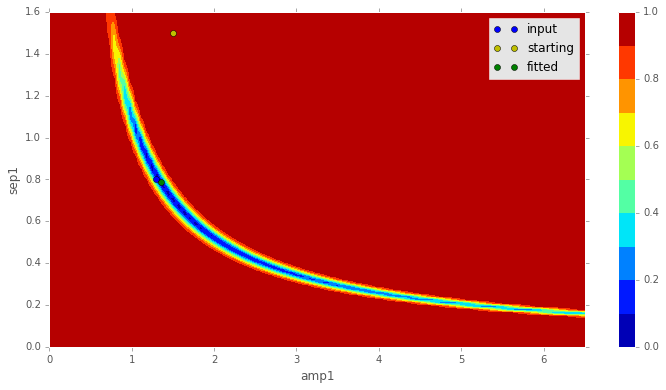

In [6]:
cx, cy, grid = lmfit.conf_interval2d(result, result, 'amp1', 'sep1', 100, 100, limits=((0.,6.5), (0., 1.6)))
plt.contourf(cx, cy, grid, np.linspace(0,1,11)) #, cmap=plt.cm.bone)
plt.xlabel('amp1'); plt.ylabel('sep1')
plt.colorbar()
lab_input, = plt.plot(1.3, 0.8, 'bo', label='input') ## input params
lab_starting, = plt.plot(1.5, 1.5, 'yo', label='starting') ## starting params
lab_fitted, = plt.plot(result.params['amp1'].value, result.params['sep1'].value, 'go', label='fitted')  ## fitted params
plt.legend([lab_input, lab_starting, lab_fitted], ['input', 'starting', 'fitted'])

The F-test is used to compare our null model, which is the best fit we have found, with an alternate model, where one of the parameters is fixed to a specific value. The value is changed until the difference between $\chi^2_0$ and $\chi^2_{f}$ can’t be explained by the loss of a degree of freedom within a certain confidence.

$F(P_{fix},N-P) = \left(\frac{\chi^2_f}{\chi^2_{0}}-1\right)\frac{N-P}{P_{fix}}$

$N$ is the number of data-points, $P$ the number of parameter of the null model. $P_{fix}$ is the number of fixed parameters (or to be more clear, the difference of number of parameters between our null model and the alternate model).

### Try my idea of using image and template separately to constrain fit...

 - Adding parameter "sep1"
 - Adding parameter "amp1"
[[Model]]
    Model(gen_dipole2)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 120
    # variables        = 2
    chi-square         = 0.130
    reduced chi-square = 0.001
[[Variables]]
    sep1:   0.81361325 +/- 0.031013 (3.81%) (init= 1.5)
    amp1:   1.31136164 +/- 0.021458 (1.64%) (init= 1.5)

         99.70%    95.00%    67.40%    _BEST_    67.40%    95.00%    99.70%
 sep1:  -0.09227  -0.06063  -0.03039   0.81361  +0.03076  +0.06214  +0.09581
 amp1:  -0.06496  -0.04249  -0.02116   1.31136  +0.02117  +0.04254  +0.06509


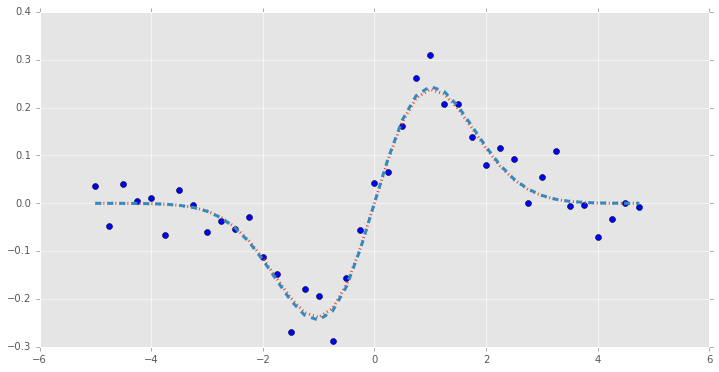

In [7]:
## Use same input data as above for direct comparison
ydata = ydataOrigNoisy
ydata[:len(xdata)] = ydata[len(xdata):2*len(xdata)] - ydata[2*len(xdata):]
result = fitDipole(ydata, xdata, amp1Start=1.5, sep1Start=1.5, fitFunc=gen_dipole2, verbose=True)
plt.plot(xdata, ydata[:len(xdata)], 'bo')
plt.plot(xdata, ydataOrig[:len(xdata)], linewidth=3, linestyle='dotted')
plt.plot(xdata, result.best_fit[:len(xdata)], linewidth=3, linestyle='dashed')
plt.show()

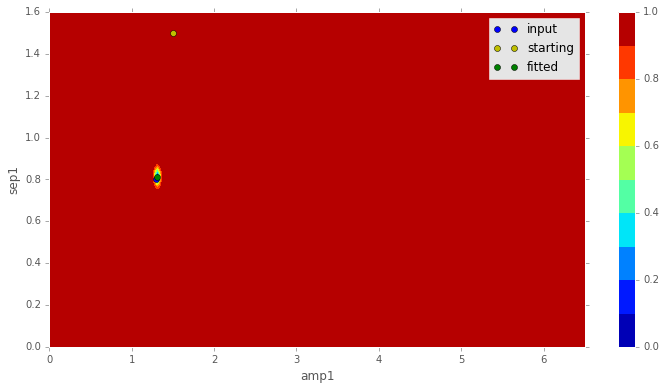

In [8]:
cx, cy, grid = lmfit.conf_interval2d(result, result, 'amp1', 'sep1', 100, 100, limits=((0.,6.5), (0., 1.6)))
plt.contourf(cx, cy, grid, np.linspace(0,1,11)) #, cmap=plt.cm.bone)
plt.xlabel('amp1'); plt.ylabel('sep1')
plt.colorbar()
lab_input, = plt.plot(1.3, 0.8, 'bo', label='input') ## input params
lab_starting, = plt.plot(1.5, 1.5, 'yo', label='starting') ## starting params
lab_fitted, = plt.plot(result.params['amp1'].value, result.params['sep1'].value, 'go', label='fitted')  ## fitted params
plt.legend([lab_input, lab_starting, lab_fitted], ['input', 'starting', 'fitted'])

### This above weights the 3 planes equally. Let's weight the dipole plane 10x more and see how it looks:

In [9]:
def fitDipole2(ydata, xdata, amp1Start=3., sep1Start=2., fitFunc=gen_dipole, verbose=False):
    gmod = lmfit.Model(fitFunc, verbose=verbose)
    weights = np.ones_like(ydata)
    weights[:len(xdata)] = 10.
    result = gmod.fit(ydata, x=xdata, weights=weights, amp1=amp1Start, sep1=sep1Start, verbose=verbose)

    if verbose: 
        print(result.fit_report(show_correl=False))
        ci = lmfit.conf_interval(result, result)
        lmfit.printfuncs.report_ci(ci)

    return result

 - Adding parameter "sep1"
 - Adding parameter "amp1"
[[Model]]
    Model(gen_dipole2)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 120
    # variables        = 2
    chi-square         = 6.520
    reduced chi-square = 0.055
[[Variables]]
    sep1:   0.81237041 +/- 0.099501 (12.25%) (init= 1.5)
    amp1:   1.31398687 +/- 0.144233 (10.98%) (init= 1.5)

         99.70%    95.00%    67.40%    _BEST_    67.40%    95.00%    99.70%
 sep1:  -0.22783  -0.16286  -0.08890   0.81237  +0.10856  +0.24182  +0.40974
 amp1:  -0.39565  -0.27089  -0.13912   1.31399  +0.14422  +0.29266  +0.45160


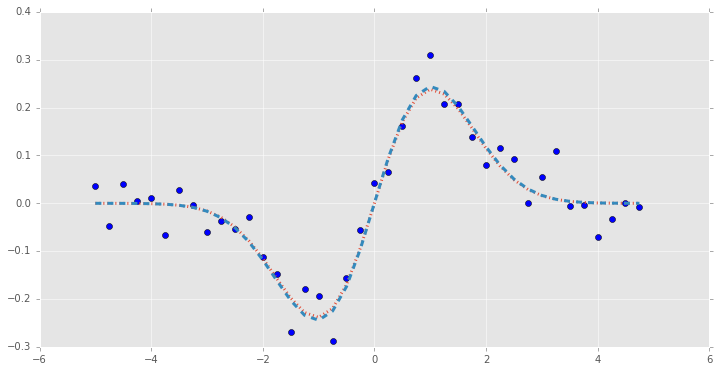

In [10]:
ydata = ydataOrigNoisy
result = fitDipole2(ydata, xdata, amp1Start=1.5, sep1Start=1.5, fitFunc=gen_dipole2, verbose=True)
plt.plot(xdata, ydata[:len(xdata)], 'bo')
plt.plot(xdata, ydataOrig[:len(xdata)], linewidth=3, linestyle='dotted')
plt.plot(xdata, result.best_fit[:len(xdata)], linewidth=3, linestyle='dashed')
plt.show()

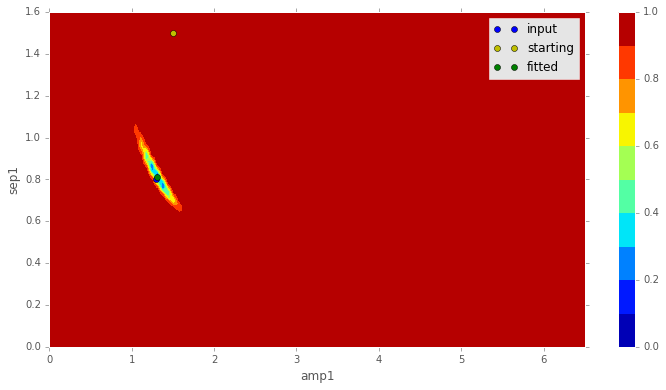

In [11]:
cx, cy, grid = lmfit.conf_interval2d(result, result, 'amp1', 'sep1', 100, 100, limits=((0.,6.5), (0., 1.6)))
plt.contourf(cx, cy, grid, np.linspace(0,1,11)) #, cmap=plt.cm.bone)
plt.xlabel('amp1'); plt.ylabel('sep1')
plt.colorbar()
lab_input, = plt.plot(1.3, 0.8, 'bo', label='input') ## input params
lab_starting, = plt.plot(1.5, 1.5, 'yo', label='starting') ## starting params
lab_fitted, = plt.plot(result.params['amp1'].value, result.params['sep1'].value, 'go', label='fitted')  ## fitted params
plt.legend([lab_input, lab_starting, lab_fitted], ['input', 'starting', 'fitted'])

## Instead of down-weighting the image planes, let's fit a background to it instead... (no background to the dipole, or maybe there should be eventually...)

In [12]:
def gen_dipole3(x, amp1=1., sep1=1., bg1=0.5):
    ypos = bg1 + amp1 * norm.pdf(x,  sep1/2., 1)
    yneg = bg1 + amp1 * norm.pdf(x, -sep1/2., 1)                  
    y = ypos - yneg
    return np.append(y, [ypos, yneg])

def fitDipole3(ydata, xdata, amp1Start=3., sep1Start=2., fitFunc=gen_dipole3, verbose=False):
    bg1start = np.median(ydata[len(xdata):])
    gmod = lmfit.Model(fitFunc, verbose=verbose)
    result = gmod.fit(ydata, x=xdata, amp1=amp1Start, sep1=sep1Start, bg1=bg1start, verbose=verbose)

    if verbose: 
        print(result.fit_report(show_correl=False))
        ci = lmfit.conf_interval(result, result)
        lmfit.printfuncs.report_ci(ci)

    return result

 - Adding parameter "bg1"
 - Adding parameter "amp1"
 - Adding parameter "sep1"
[[Model]]
    Model(gen_dipole3)
[[Fit Statistics]]
    # function evals   = 19
    # data points      = 120
    # variables        = 3
    chi-square         = 0.130
    reduced chi-square = 0.001
[[Variables]]
    bg1:    0.49997636 +/- 0.004567 (0.91%) (init= 0.5452806)
    amp1:   1.31144068 +/- 0.026415 (2.01%) (init= 1.5)
    sep1:   0.81358090 +/- 0.031765 (3.90%) (init= 1.5)

         99.70%    95.00%    67.40%    _BEST_    67.40%    95.00%    99.70%
 bg1 :  -0.01384  -0.00905  -0.00452   0.49998  +0.00451  +0.00905  +0.01383
 amp1:  -0.07991  -0.05228  -0.02604   1.31144  +0.02607  +0.05240  +0.08021
 sep1:  -0.09406  -0.06191  -0.03108   0.81358  +0.03156  +0.06387  +0.09868


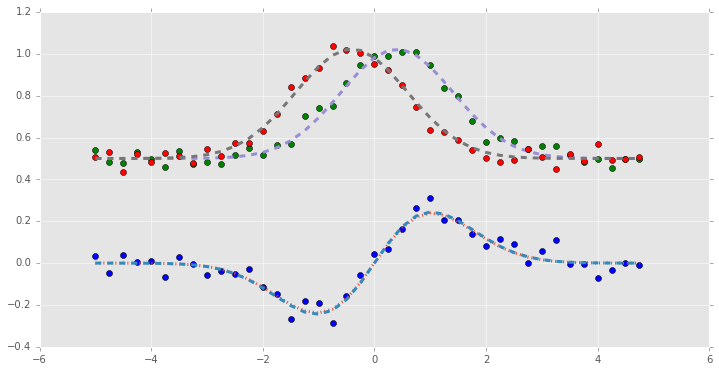

In [13]:
ydata = ydataOrigNoisy.copy()    ## copy it b/c we're gonna mess with it
ydata[len(xdata):2*len(xdata)] += 0.5
ydata[2*len(xdata):] += 0.5
ydata[:len(xdata)] = ydata[len(xdata):2*len(xdata)] - ydata[2*len(xdata):]
result = fitDipole3(ydata, xdata, amp1Start=1.5, sep1Start=1.5, fitFunc=gen_dipole3, verbose=True)
plt.plot(xdata, ydata[:len(xdata)], 'bo')
plt.plot(xdata, ydataOrig[:len(xdata)], linewidth=3, linestyle='dotted')
plt.plot(xdata, result.best_fit[:len(xdata)], linewidth=3, linestyle='dashed')
plt.plot(xdata, ydata[len(xdata):2*len(xdata)], 'go')
plt.plot(xdata, result.best_fit[len(xdata):2*len(xdata)], linewidth=3, linestyle='dashed')
plt.plot(xdata, ydata[2*len(xdata):], 'ro')
plt.plot(xdata, result.best_fit[2*len(xdata):], linewidth=3, linestyle='dashed')
plt.show()

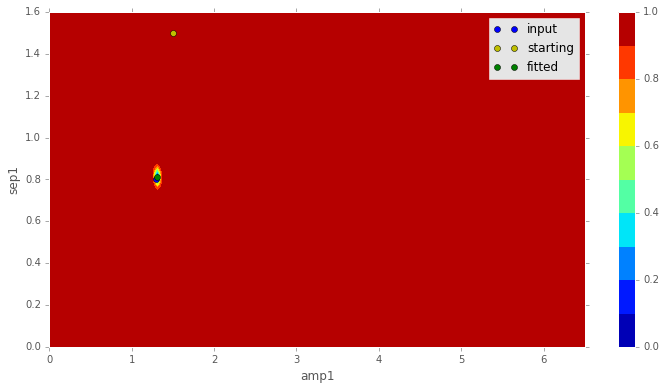

In [14]:
cx, cy, grid = lmfit.conf_interval2d(result, result, 'amp1', 'sep1', 100, 100, limits=((0.,6.5), (0., 1.6)))
plt.contourf(cx, cy, grid, np.linspace(0,1,11)) #, cmap=plt.cm.bone)
plt.xlabel('amp1'); plt.ylabel('sep1')
plt.colorbar()
lab_input, = plt.plot(1.3, 0.8, 'bo', label='input') ## input params
lab_starting, = plt.plot(1.5, 1.5, 'yo', label='starting') ## starting params
lab_fitted, = plt.plot(result.params['amp1'].value, result.params['sep1'].value, 'go', label='fitted')  ## fitted params
plt.legend([lab_input, lab_starting, lab_fitted], ['input', 'starting', 'fitted'])

## Now let's add a linear background gradient...

In [15]:
def gen_dipole4(x, amp1=1., sep1=1., bg1=0.5, bgslope1=0.02):
    ypos = bg1 + bgslope1*x + amp1 * norm.pdf(x,  sep1/2., 1)
    yneg = bg1 + bgslope1*x + amp1 * norm.pdf(x, -sep1/2., 1)                  
    y = ypos - yneg
    return np.append(y, [ypos, yneg])

def fitDipole4(ydata, xdata, amp1Start=3., sep1Start=2., bgslope1start=0., fitFunc=gen_dipole4, verbose=False):
    bg1start = np.median(ydata[len(xdata):])
    gmod = lmfit.Model(fitFunc, verbose=verbose)
    result = gmod.fit(ydata, x=xdata, amp1=amp1Start, sep1=sep1Start, bg1=bg1start, bgslope1=bgslope1start,
                      verbose=verbose)

    if verbose: 
        print(result.fit_report(show_correl=False))
        ci = lmfit.conf_interval(result, result)
        lmfit.printfuncs.report_ci(ci)

    return result

 - Adding parameter "bg1"
 - Adding parameter "bgslope1"
 - Adding parameter "amp1"
 - Adding parameter "sep1"
[[Model]]
    Model(gen_dipole4)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 120
    # variables        = 4
    chi-square         = 1.568
    reduced chi-square = 0.014
[[Variables]]
    bg1:        0.20271693 +/- 0.015947 (7.87%) (init= 0.5957395)
    bgslope1:   0.23284845 +/- 0.004506 (1.94%) (init= 0)
    amp1:       1.29758660 +/- 0.092029 (7.09%) (init= 1.5)
    sep1:       0.82975006 +/- 0.112518 (13.56%) (init= 1.5)

             99.70%    95.00%    67.40%    _BEST_    67.40%    95.00%    99.70%
 bg1     :  -0.04834  -0.03157  -0.01572   0.20272  +0.01570  +0.03151  +0.04821
 bgslope1:  -0.01366  -0.00893  -0.00445   0.23285  +0.00445  +0.00893  +0.01366
 amp1    :  -0.27567  -0.18059  -0.09020   1.29759  +0.09059  +0.18224  +0.27950
 sep1    :  -0.30833  -0.20520  -0.10436   0.82975  +0.10985  +0.22747  +0.36108


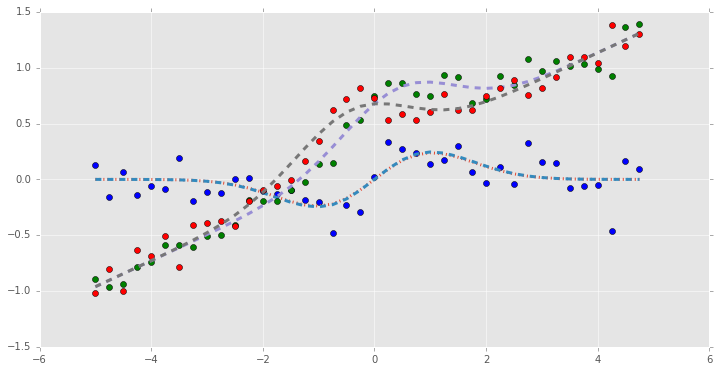

In [16]:
ydata = ydataOrig + np.random.normal(scale=0.1, size=ydataOrig.shape) ## make it super noisy
ydata[len(xdata):2*len(xdata)] += 0.2 + 0.234*xdata
ydata[2*len(xdata):] += 0.2 + 0.234*xdata
ydata[:len(xdata)] = ydata[len(xdata):2*len(xdata)] - ydata[2*len(xdata):]
result = fitDipole4(ydata, xdata, amp1Start=1.5, sep1Start=1.5, fitFunc=gen_dipole4, verbose=True)
plt.plot(xdata, ydata[:len(xdata)], 'bo')
plt.plot(xdata, ydataOrig[:len(xdata)], linewidth=3, linestyle='dotted')
plt.plot(xdata, result.best_fit[:len(xdata)], linewidth=3, linestyle='dashed')
plt.plot(xdata, ydata[len(xdata):2*len(xdata)], 'go')
plt.plot(xdata, result.best_fit[len(xdata):2*len(xdata)], linewidth=3, linestyle='dashed')
plt.plot(xdata, ydata[2*len(xdata):], 'ro')
plt.plot(xdata, result.best_fit[2*len(xdata):], linewidth=3, linestyle='dashed')
plt.show()

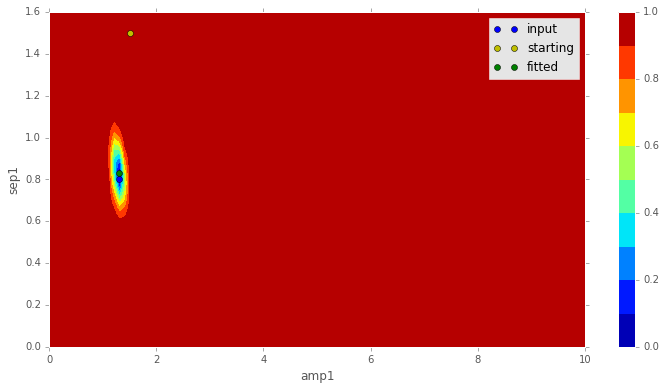

In [17]:
cx, cy, grid = lmfit.conf_interval2d(result, result, 'amp1', 'sep1', 100, 100, limits=((0.,10.), (0., 1.6)))
plt.contourf(cx, cy, grid, np.linspace(0,1,11)) #, cmap=plt.cm.bone)
plt.xlabel('amp1'); plt.ylabel('sep1')
plt.colorbar()
lab_input, = plt.plot(1.3, 0.8, 'bo', label='input') ## input params
lab_starting, = plt.plot(1.5, 1.5, 'yo', label='starting') ## starting params
lab_fitted, = plt.plot(result.params['amp1'].value, result.params['sep1'].value, 'go', label='fitted')  ## fitted params
plt.legend([lab_input, lab_starting, lab_fitted], ['input', 'starting', 'fitted'])

Compare this vs. if we did not have the pre-subtraction images.

 - Adding parameter "sep1"
 - Adding parameter "amp1"
[[Model]]
    Model(gen_dipole)
[[Fit Statistics]]
    # function evals   = 374
    # data points      = 40
    # variables        = 2
    chi-square         = 0.812
    reduced chi-square = 0.021
[[Variables]]
    sep1:   0.01234482 +/- 147.5575 (1195299.28%) (init= 1.5)
    amp1:   87.5240974 +/- 1.01e+06 (1159525.83%) (init= 1.5)



/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/confidence.py:298: UserWarning: Warning, rel_change=0.0 < 0.01  at iteration 1 and prob(sep1=0.00987585900272) = 0.0 < max(sigmas).
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/confidence.py:292: UserWarning: Warning, maxiter=200 reachedand prob(sep1=0.50860673864) = 0.306654586006 < max(sigmas).
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/confidence.py:298: UserWarning: Warning, rel_change=0.0 < 0.01  at iteration 1 and prob(amp1=105.028916944) = 0.0 < max(sigmas).


         99.70%    95.00%    67.40%    _BEST_    67.40%    95.00%    99.70%
 sep1:      -inf      -inf      -inf   0.01234      +inf      +inf      +inf
 amp1: -87.21440 -87.00821 -86.59421  87.52410      +inf      +inf      +inf


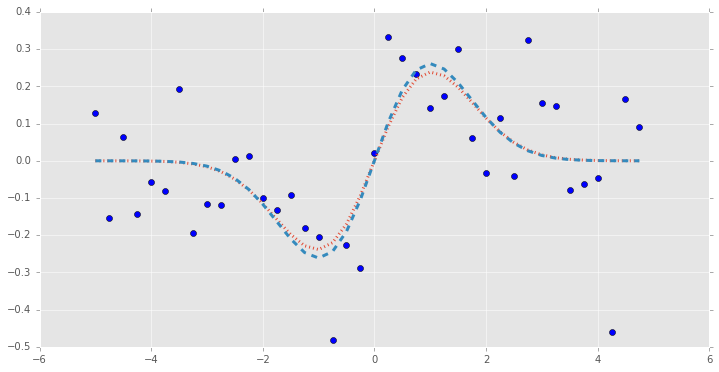

In [18]:
ydata = ydata[:len(xdata)]    ## only fit the dipole (not pos/neg images)
result = fitDipole(ydata, xdata, amp1Start=1.5, sep1Start=1.5, fitFunc=gen_dipole, verbose=True)
plt.plot(xdata, ydata, 'bo')
plt.plot(xdata, ydataOrig[:len(xdata)], linewidth=3, linestyle='dotted')
plt.plot(xdata, result.best_fit, linewidth=3, linestyle='dashed')
plt.show()

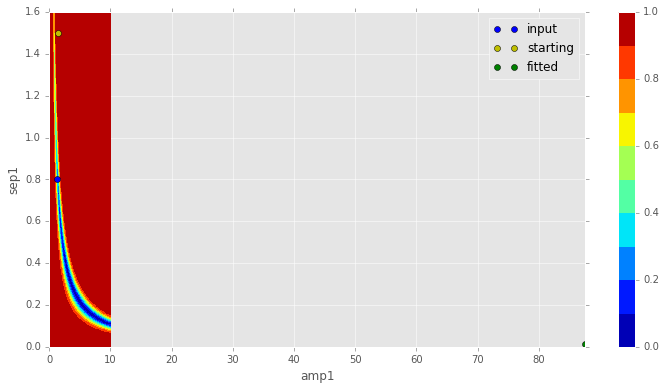

In [19]:
cx, cy, grid = lmfit.conf_interval2d(result, result, 'amp1', 'sep1', 100, 100, limits=((0.,10.), (0., 1.6)))
plt.contourf(cx, cy, grid, np.linspace(0,1,11)) #, cmap=plt.cm.bone)
plt.xlabel('amp1'); plt.ylabel('sep1')
plt.colorbar()
lab_input, = plt.plot(1.3, 0.8, 'bo', label='input') ## input params
lab_starting, = plt.plot(1.5, 1.5, 'yo', label='starting') ## starting params
lab_fitted, = plt.plot(result.params['amp1'].value, result.params['sep1'].value, 'go', label='fitted')  ## fitted params
plt.legend([lab_input, lab_starting, lab_fitted], ['input', 'starting', 'fitted'])

TBD: possible different pos/neg background parameters and different pos/neg flux parameters.

Also possible background gradient in dipole image plane.

Now let's try Zeljko's idea of just fitting the coadd of the images + the diffim.

In [20]:
def gen_dipole5(x, amp1=1., sep1=1., bg1=0.5, bgslope1=0.02):
    ypos = bg1 + bgslope1*x + amp1 * norm.pdf(x,  sep1/2., 1)
    yneg = bg1 + bgslope1*x + amp1 * norm.pdf(x, -sep1/2., 1)                  
    #y = ypos - yneg
    return np.append(ypos + yneg, [ypos - yneg])

def fitDipole5(ydata, xdata, amp1Start=3., sep1Start=2., bgslope1start=0., fitFunc=gen_dipole4, verbose=False):
    bg1start = np.median(ydata[len(xdata):])
    gmod = lmfit.Model(fitFunc, verbose=verbose)
    result = gmod.fit(ydata, x=xdata, amp1=amp1Start, sep1=sep1Start, bg1=bg1start, bgslope1=bgslope1start,
                      verbose=verbose)

    if verbose: 
        print(result.fit_report(show_correl=False))
        ci = lmfit.conf_interval(result, result)
        lmfit.printfuncs.report_ci(ci)

    return result

 - Adding parameter "bg1"
 - Adding parameter "bgslope1"
 - Adding parameter "amp1"
 - Adding parameter "sep1"
[[Model]]
    Model(gen_dipole5)
[[Fit Statistics]]
    # function evals   = 23
    # data points      = 80
    # variables        = 4
    chi-square         = 1.510
    reduced chi-square = 0.020
[[Variables]]
    bg1:        0.19850238 +/- 0.013889 (7.00%) (init=-0.01606567)
    bgslope1:   0.23304339 +/- 0.003863 (1.66%) (init= 0)
    amp1:       1.35829665 +/- 0.082618 (6.08%) (init= 1.5)
    sep1:       0.89228240 +/- 0.138151 (15.48%) (init= 1.5)

             99.70%    95.00%    67.40%    _BEST_    67.40%    95.00%    99.70%
 bg1     :  -0.04259  -0.02766  -0.01373   0.19850  +0.01373  +0.02766  +0.04259
 bgslope1:  -0.01185  -0.00770  -0.00382   0.23304  +0.00382  +0.00770  +0.01185
 amp1    :  -0.25335  -0.16455  -0.08168   1.35830  +0.08168  +0.16455  +0.25335
 sep1    :  -0.41262  -0.26673  -0.13202   0.89228  +0.13193  +0.26624  +0.41147


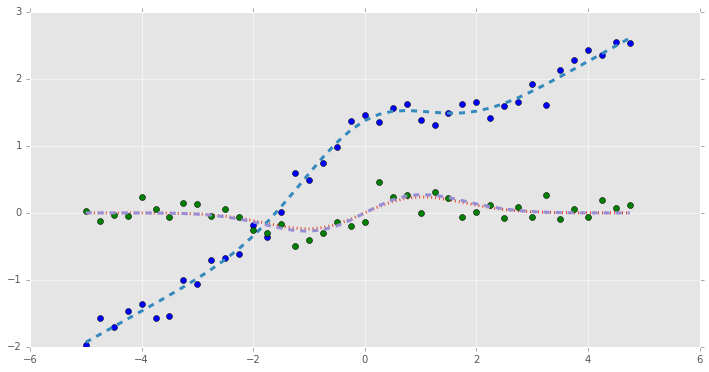

In [21]:
ydata = ydataOrig + np.random.normal(scale=0.1, size=ydataOrig.shape) ## make it super noisy
ydata[len(xdata):2*len(xdata)] += 0.2 + 0.234*xdata
ydata[2*len(xdata):] += 0.2 + 0.234*xdata
ydata[:len(xdata)] = ydata[len(xdata):2*len(xdata)] + ydata[2*len(xdata):]
ydata[len(xdata):2*len(xdata)] = ydata[len(xdata):2*len(xdata)] - ydata[2*len(xdata):]
ydata = ydata[:2*len(xdata)]
result = fitDipole5(ydata, xdata, amp1Start=1.5, sep1Start=1.5, fitFunc=gen_dipole5, verbose=True)
plt.plot(xdata, ydata[:len(xdata)], 'bo')
plt.plot(xdata, ydataOrig[:len(xdata)], linewidth=3, linestyle='dotted')
plt.plot(xdata, result.best_fit[:len(xdata)], linewidth=3, linestyle='dashed')
plt.plot(xdata, ydata[len(xdata):], 'go')
plt.plot(xdata, result.best_fit[len(xdata):], linewidth=3, linestyle='dashed')
plt.show()

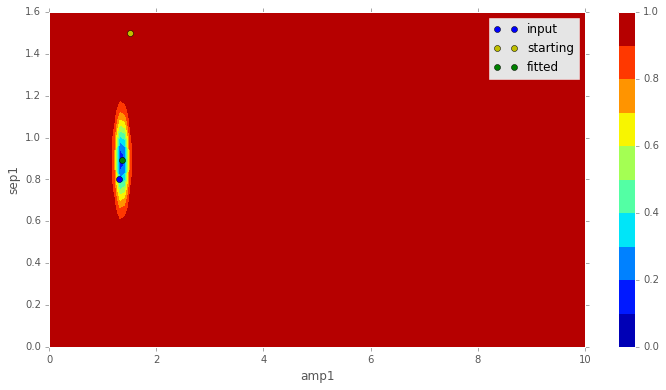

In [22]:
cx, cy, grid = lmfit.conf_interval2d(result, result, 'amp1', 'sep1', 100, 100, limits=((0.,10.), (0., 1.6)))
plt.contourf(cx, cy, grid, np.linspace(0,1,11)) #, cmap=plt.cm.bone)
plt.xlabel('amp1'); plt.ylabel('sep1')
plt.colorbar()
lab_input, = plt.plot(1.3, 0.8, 'bo', label='input') ## input params
lab_starting, = plt.plot(1.5, 1.5, 'yo', label='starting') ## starting params
lab_fitted, = plt.plot(result.params['amp1'].value, result.params['sep1'].value, 'go', label='fitted')  ## fitted params
plt.legend([lab_input, lab_starting, lab_fitted], ['input', 'starting', 'fitted'])